In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [4]:
class particleClass():
    nMade=0
    def __init__(self):
        self.pos=np.zeros(3)
        self.vel=np.zeros(3)
        self.m=0
        self.index=particleClass.nMade
        particleClass.nMade+=1

In [20]:
def runSim(particles,boxSize,dt,endTime,nPlots): #simple leapfrog integration
    nTimestep=int(endTime/dt)
    for i in range(nTimestep):
        for p in particles: #to do leapfrog integration need to update all positions
            p.pos=(p.pos+dt*p.vel) % boxSize
        for p in particles: #then compute new accelerations on this evolved systems
            acc=findAcc(particles,p,boxSize)
            p.vel=p.vel+dt*acc
        if (i%int(nTimestep/nPlots)==0): #periodically plots the state of the box
            plotSim(particles,i*dt,i/int(nTimestep/nPlots))

def findAcc(particles,thisParticle,boxSize):
    pos=thisParticle.pos
    index=thisParticle.index
    acc=np.zeros(3)
    for p in particles:
        e_r=(pos-p.pos) #vector from loop particle to this particle
        for i in range(3): #checks periodic boundary conditions
            if (e_r[i] > boxSize/2):
                e_r[i]-=boxSize
            elif (e_r[i] < -boxSize/2):
                e_r[i]+=boxSize
        r=np.linalg.norm(e_r)+0.1 #0.1 is gravitational softening length
        e_r=e_r/r # normalises to make into unit vector
        if (p.index == index): # the particle should feel no force from itself
            continue
        acc+=(-p.m/(r**2))*e_r # == GM/r^3 _r_ in units where G=1
    return acc

def initSim(nParticles,boxSize):
    pMass=1 #mass of each particle
    particleClass.nMade=0
    particles=[]
    for i in range(nParticles):
        newP=particleClass()
        newP.pos=boxSize*np.random.random(3)
        newP.vel=(boxSize/100)*(1-2*np.random.random(3)) # units be damned...
        newP.m=pMass
        particles.append(newP)
    return particles

def plotSim(particles,time,whichPlot):
    fig1=plt.subplot(grid[int(whichPlot),0])
    fig1.set_xlim(0,boxSize)
    fig1.set_ylim(0,boxSize)
    fig1.set_xlabel("x")
    fig1.set_ylabel("y")
    fig1.set_title('t='+str(time))
    v=np.zeros(len(particles))
    for i,p in enumerate(particles):
        fig1.scatter(p.pos[0],p.pos[1],color=cmap(p.index/particleClass.nMade),s=1)
        #optionally add velocities, currently not very readable
        #fig1.quiver(p.pos[0],p.pos[1],p.vel[0],p.vel[1])
        v[i]=np.linalg.norm(p.vel)
    fig2=plt.subplot(grid[int(whichPlot),1])
    maxV=np.max(v)
    nBin=20
    fig2.set_xlim(0,np.max(v))
    fig2.hist(v,bins=nBin,range=(0,maxV),color=cmap(0.7),edgecolor=cmap(0.7))
    fig2.set_xlabel("v")
    fig2.set_ylabel("n(v)")

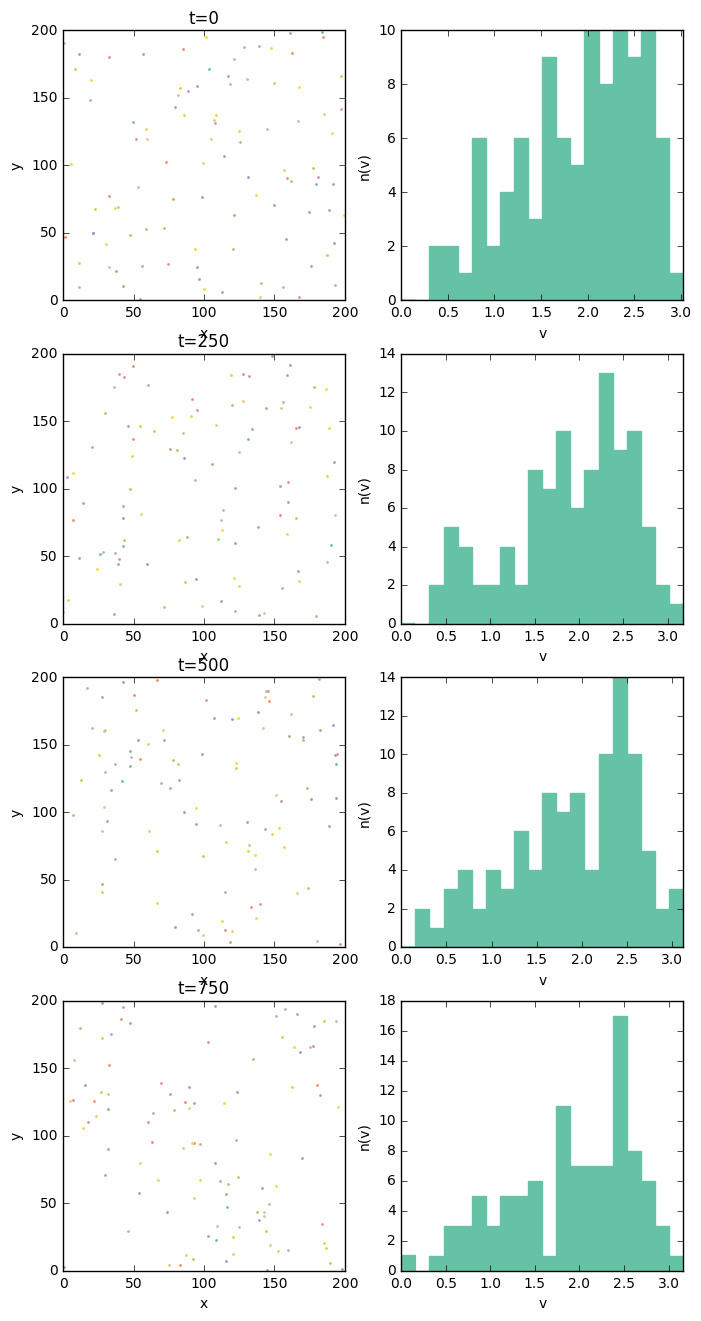

In [21]:
nParticles=40
boxSize=200 # not periodic!
dt=0.5 # in units where G=1
endTime=100
#in these units it takes roughly t=80 for two particles of mass 1 
#to cross corner to corner of boxSize=10 and come to rest

nPlots=4
plots=plt.figure(figsize=(8,nPlots*4))
grid=matplotlib.gridspec.GridSpec(nPlots,2)
cmap=matplotlib.cm.get_cmap('Set2')

particles=initSim(nParticles,boxSize)
runSim(particles,boxSize,dt,endTime,nPlots)

plt.show()